# Sprawozdanie Laboratorium 9 - OCR
#### Joanna Mikołajczyk, grupa środa 8:00

### Funkcje pomocnicze, wykorzystywane przez główny algorytm

Importowane moduły.

In [1]:
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from skimage.morphology import (square, rectangle, closing)
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from matplotlib import cm

Funkcje pomocnicze do <b>wczytywania i rysowania obrazów</b>.

In [2]:
def image_matrix(image_path):
    return ndimage.imread(image_path, flatten=True)

In [3]:
def pretty_plot(image, cmap='gray', title=None, figsize=(10,10)): 
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.show()

Funkcja <b>tresholded_image</b> jako argument przyjmuje macierz reprezentującą obraz, a także próg, którego <b>domyślna wartość wynosi 0.85</b>. Finalny próg wyznaczam jako iloczyn progu oraz wartości maksymalnej pikseli na obrazie. <b>Wszystkie wartości poniżej progu przyjmują wartość 0.</b>

In [4]:
def tresholded_image(image, treshold=0.85):
    tresholded_image = np.copy(image)
    tresholded_image[image < treshold * np.amax(image)] = 0
    return tresholded_image

Funkcja <b> binarize_image </b> jako argument przyjmuje macierz reprezentującą obraz, a także próg binarayzacji, <b>domyślna wartość progu wynosi 0.5</b>. Finalny próg binaryzacji wyznaczam jako iloczyn progu oraz wartości maksymalnej pikseli na obrazie. <b> Wartości powyżej progu przyjmują wartość 1, a poniżej 0. </b>

In [5]:
def binarize_image(image, treshold=0.5):
    binarized_image = np.copy(image)
    binarized_image[image < treshold * np.amax(image)] = 0
    binarized_image[image >= treshold * np.amax(image)] = 1
    return binarized_image

### Splot

Funkcja <b>convolve</b> dokokune operacji splotu obrazu wejściowego - image, oraz wzorca - pattern. <b>Zwraca macierz korelacji.</b> Do wyznaczenia korelacji wykorzystuję <b>odwrotną transformację Fouriera</b> na macierzy otrzymanej w wyniku mnożenia transformat obrazu oraz wzorca.

In [6]:
def convolve(image, pattern):
    f_pattern = np.fft.fft2(np.rot90(pattern,2), image.shape)
    f_image = np.fft.fft2(image)
    m = np.multiply(f_image, f_pattern)
    corr = np.fft.ifft2(m)
    corr = np.abs(corr)
    corr = corr.astype(np.float)
    return corr

Funkcje pomocnicze do <b>znajdowania wzorca</b> oraz <b>naniesienia znalezionego wzorca na obrazie wejściowym</b>.

In [7]:
def find_pattern(image, pattern, treshold=0.90):
    corr = convolve(image, pattern)
    matched_pattern = tresholded_image(corr, treshold=treshold)
    return matched_pattern

In [8]:
def matched_pattern_on_image(image, pattern):
    matched_patterns = np.copy(image)
    # dim image
    matched_patterns *= 0.3
    matched_patterns[pattern > 0] = 255
    return matched_patterns

### Transformacja Hough'a

Transformacja Hougha to <b>metoda wykrywania regularnych kształtów</b> w widzeniu komputerowym. Oryginalna metoda Hougha służy do wykrywania prostych. W moim algorytmie posłużyłam się nią <b>do wykrycia linii w tekście</b>, już po znalezieniu na nim korelacji z wzorcowymi znakami. 

Funkcja realizująca <b>transformację Hough'a.</b>

In [9]:
def hough_transform(image):
    
    lines_range = []

    # Classic straight-line Hough transform
    h, theta, d = hough_line(image)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap=cm.gray, aspect=1/1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
 
        # append found line range
        lines_range.append((y0, y1))

        ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    
    return lines_range

### Dane wejściowe

Tablice <b>znaków, które mają zostać wykryte na obrazie wejściowym</b>. Stanowią one zbiór:
- małych liter alfabetu łacińskiego,
- znaki:  ',', '?', '!' oraz'.' (ze względów praktycznych zapisane jako '_'),
- cyfr od 0 do 9.

Dodatkowo dla porównania działania algorytmu ze względu na zawartość zbioru znaków do wykrycia, zdefiniowałam zbiór <b>z cyframi</b> oraz zbiór <b>bez cyfr</b>.

In [10]:
my_signs = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '_', ',', '?', '!']

In [11]:
my_signs_with_numbers = my_signs + [
    '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

Przygotowałam <b>dwa zbiory czcionek</b> do przetestowania: <b>bezszeryfową (Open Sans)</b> oraz <b>szeryfowę (EB Garamond).</b> Zbiór zawiera znaki o rozmiarze 20. Przykładowe znaki wyglądają tak:

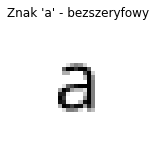

In [12]:
pretty_plot(image_matrix('images/signs/sans_serif/a.png'), title='Znak \'a\' - bezszeryfowy', figsize=(2,2))

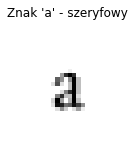

In [13]:
pretty_plot(image_matrix('images/signs/serif/a.png'), title='Znak \'a\' - szeryfowy', figsize=(2,2))

Przygotowałam kilka <b>obrazów testowych</b> z tekstem w wyżej wymienionych czcionkach do przetestowania.

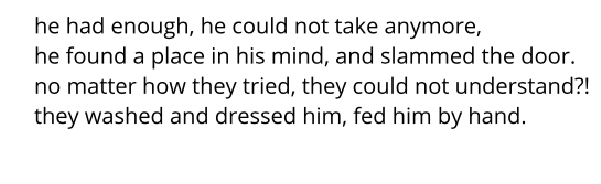

In [14]:
text_image = image_matrix('images/texts/sans_serif/text_1.png')
pretty_plot(text_image)

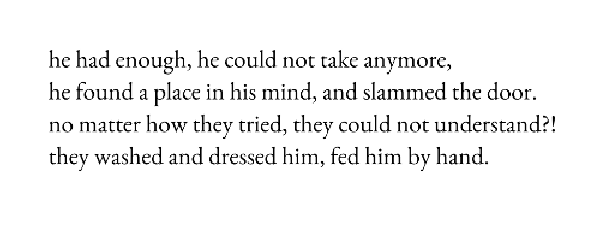

In [15]:
text_image = image_matrix('images/texts/serif/text_1.png')
pretty_plot(text_image)

A także <b>obraz z szumem.</b>

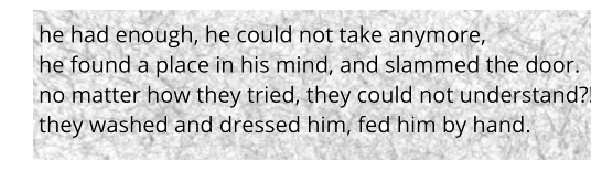

In [16]:
text_image = image_matrix('images/texts/sans_serif/text_1_with_noise.png')
pretty_plot(text_image)

# Główny algorytm

### Opis danych wejściowych oraz parametrów algorytmu

Funkcja <b>ocr_recognize_text</b> to funckja realizująca prosty algorytm OCR - rozpoznawania tekstu na obrazku. Jej argumenty to:

- <b>text_image</b> - macierz z obrazem wejściowym, na którym znajduje się tekst,
- <b>signs</b> - tablica znaków, które mają zostać wykryte (porównanie rozpoznawania z cyframi/bez),
- <b>bias</b> - przesunięcie wartości pikseli względem koloru czarnego,
- <b>correlation_treshold</b> - wartość, która określa próg podobieństwa,
- <b>square_size</b> - wartość, którą wykorzystuję podczas doboru wielkości dopełnienia,
- <b>remove_noise</b> - zmienna typu bool, określająca czy chcemy usunąć szum, czy nie.

### Opis działania

<b> 1. Przekształcenie obrazu wejściowego:</b>
   - zamiana obrazu wejściowego, tak aby białe pole miało wartość 0, a czarne 255, a nie na odwrót,
   - suwanie szumu z obrazu wejściowego - jeśli parametr remove_noise został podany jako True,
   - omniejszenie wartości pikseli na obrazie wejściowym o podaną wartość bias - dla poprawy działania algorytmu.<br><br>
<b>2. Wyszukiwanie wzorców na przekształconym obrazie wejściowym:</b>
   - wczytanie wzorcowego obrazu znaku,
   - wyszukanie za pomocą operacji splotu znaku w tekście,
   - zapisanie znaku oraz wartości korelacji w słowniku - jako wartość dla klucza oznaczającego współrzędne piksela, 
   - powtórzenie dla każdego znaku ze zbioru.
<br><br>
<b>3. Detekcja linii: </b>   
   - wykorzystanie algorytmu Hough'a w celu znalezienia linii na obrazie wejściowym, analizie poddawany jest obraz na którym zaznaczono piksele, na których wykryto znaki w kroku 2.
<br><br>
<b>4. Detekcja spacji:</b>
   - morfologiczna operacja domknięcia na zbinaryzowanym obrazie wejściowym,
   - wykrycie spacji w każdej znalezionej linii (1 - słowo, 0 - linia),
   - zapisanie w których pozycjach na znalezionych liniach została wykryta spacja.
<br><br>
<b>5. Usunięcie szumu w znalezionych wzorcach:</b>
   - zignorowanie tych miejsc na obrazie, w których nie zostały znalezione linie. 
<br><br>
<b>6. Tagowanie znaków:</b>
   - morfologiczna operacja domknięcia na obrazie pikseli, w których znaleziono wzorzec,
   - otagowanie powstałych na liniach grup pikseli,
   - znalezienie dla każdej grupy środka masy - jako współrzędna na osi pionowej przyjmujemy linie ze zbioru znalezionych linii, na osi poziomej średnią współprzędnych
<br><br>
<b>7. Wybranie reprezentanta dla znaku:</b>
   - dla każdej grupy pikseli wybranie wszystkich znaków ze słownika z kroku 2,
   - wybranie znaku o najwyżej wartości korelacji jako reprezentanta.
<br><br>
<b>8. Przeczytanie tekstu:</b>
   - dla każdej znalezionej linii odczytanie znalezionych na niej znaków,
   - elementem tego kroku jest sprawdzenie, czy pomiędzy dwoma znalezionymi znakami znajduje się spacja.

In [17]:
def ocr_recognize_text(text_image, signs, font_type='serif', bias=50, correlation_treshold=0.83, square_size=4, remove_noise=False):
    
    # plot input image
    pretty_plot(text_image, title='Input image with text to detect')
    
    # reverse black and white
    reversed_image = 255 - text_image
    
    # remove noise
    if remove_noise:
        reversed_image = tresholded_image(reversed_image, treshold=0.3)

    # move by bias value
    moved_text = reversed_image - bias
    
    # find patterns
    found_signs = OrderedDict()
    for sign in signs:
        # load and convert sign image
        sign_image = image_matrix('images/signs/{}/{}.png'.format(font_type, sign))
        moved_sign = 255 - sign_image - bias
        if sign == '_':
            sign = '.'
        
        # count translation of sign coordinates
        translation_x = int(sign_image.shape[0] / 2)
        translation_y = int(sign_image.shape[1] / 2)
        
        # find patterns
        matched_pattern = find_pattern(moved_text, moved_sign, treshold=correlation_treshold)
        matched_text = matched_pattern_on_image(text_image, matched_pattern)

        # insert into found_signs
        for x in range(matched_pattern.shape[0]):
            for y in range(matched_pattern.shape[1]):
                value = matched_pattern[x][y]
                if value != 0:
                    pixel_coord = (x - translation_x, y - translation_y)
                    pixel_value = value
                    if pixel_coord in found_signs.keys():
                        found_signs[pixel_coord].append((sign, pixel_value))
                    else:
                        found_signs[pixel_coord] = [(sign, pixel_value)]
                 
    # found patterns on image
    keys_image = np.zeros(text_image.shape)
    for (x, y) in found_signs.keys():
        keys_image[x, y] = 1
        
    pretty_plot(matched_pattern_on_image(text_image, keys_image), 
                    title='Matched patterns on input image with all found patterns') 
   
           
    # find text lines
    lines_range = hough_transform(keys_image)
       
    lines_x = []
    for (y0, y1) in lines_range:
        lines_x.append(int(y0) - int(y1-y0))
        
    lines_x.sort()
    
    # morphology closing on binarized image 
    closed_reversed_image = binarize_image(closing(reversed_image, rectangle(10,6)))

    pretty_plot(closed_reversed_image, title='Binarized and closed words in text image') 
    
    # find spaces
    
    lines_spaces_area = []
    # find spaces lines
    for line in lines_x:
        line_spaces_area = []

        for i in range(len(closed_reversed_image[line])):
            if closed_reversed_image[line][i] == 0:
                line_spaces_area.append(i)
        lines_spaces_area.append(line_spaces_area)
 
    
    # remove pixels outside of detected lines

    lines_x_with_margin = [[x-3, x-2, x-1, x, x+1, x+2, x+3] for x in lines_x]
    lines_x_with_margin = [x for sublist in lines_x_with_margin for x in sublist]
    
    for x in range(keys_image.shape[0]):
        if x not in lines_x_with_margin:
            keys_image[x,:] = np.zeros(len(keys_image[x,:]))

    # morphology closing
    keys_image = closing(keys_image, square(square_size))
    
    pretty_plot(matched_pattern_on_image(text_image, keys_image), 
                    title='Matched patterns on input image without patterns found outside of lines') 
    
   
    # label to form groups of close pixels
    labeled_array, num_features = ndimage.label(keys_image)

    grouped_pixels = OrderedDict()

    for x in range(keys_image.shape[0]):
        for y in range(keys_image.shape[1]):
            feature = labeled_array[x][y]
            if feature != 0:
                if feature in grouped_pixels.keys():
                    grouped_pixels[feature].append((x, y))
                else:
                    grouped_pixels[feature] = [(x, y)]
          
    
    # take, from pairs of (x, y), x belonging to one of lines in lines_x, y as mean of all y in group

    grouped_pixels_coordinates = OrderedDict()
    
    for group in grouped_pixels.keys():

        pixels_coords = grouped_pixels[group]
        pixels_x_coords = []
        pixels_y_coords = []
        for (x, y) in pixels_coords:
            pixels_x_coords.append(x)
            pixels_y_coords.append(y)
             
        pixels_x_coord = int(np.mean(pixels_x_coords))
        pixels_y_coord = int(np.mean(pixels_y_coords))
        
        for x in lines_x:
            if abs(pixels_x_coord - x) <= 1:
                pixels_x_coord = x
        
        grouped_pixels_coordinates[group] = (pixels_x_coord, pixels_y_coord)


    grouped_found_signs = OrderedDict()

    for group in grouped_pixels.keys():
        group_values = []
        for (x, y) in grouped_pixels[group]:
            if (x, y) in found_signs.keys():
                for (sign, value) in found_signs[(x, y)]:
                    group_values.append((sign, value))

        grouped_found_signs[group] = group_values
        
    # filter found signs by choosing the one with the highest correlation
        
    filtered_found_signs = OrderedDict()
    
    for key in grouped_found_signs.keys():
        signs = []
        values = []

        for sign, value in grouped_found_signs[key]:
            signs.append(sign)
            values.append(value)
        
        if len(values) != 0:        
            final_sign = signs[np.argmax(values)]
            filtered_found_signs[grouped_pixels_coordinates[key]] = final_sign
        
    lines_y = []

    for line_x in lines_x:
        line_y = []
        for (x, y) in filtered_found_signs.keys():
            if x == line_x:
                line_y.append(y)
        line_y.sort()
        lines_y.append(line_y)
        
    # read line by line
        
    text = ''
    for i in range(len(lines_x)):
        line = ''
        x = lines_x[i]
        
        line += filtered_found_signs[(x, lines_y[i][0])]
        for j in range(1, len(lines_y[i])):
            y_1 = lines_y[i][j-1]
            y_2 = lines_y[i][j]   
            diff = y_2 - y_1
            space = int(y_2 - diff/2)
            
            if space in lines_spaces_area[i]:
                line += ' '
            line += filtered_found_signs[(x, y_2)]
                 
        text += line
        text += '\n'

    # return read text

    return text      

# Prezentacja działania

Pomocnicza funkcja do <b>oceny poprawności działania algorytmu OCR, </b> która zlicza liczbę wystąpień każdej litery w tekście, co pozwala na porównanie ilości pokrycia liter.

Niestety ze względu na sposób działania algorytmu nie ma gwarancji, że zostanie znaleziona ilość liter taka jak faktycznie jest na obrazie wejściowym, stąd porównanie procentowe pokrycia liter jest trudne do zrealizowania.

In [18]:
def signs_dictionary(text):
    signs = list(text)
    unique_signs = list(set(signs))
    unique_signs.sort()
    signs_dict = OrderedDict()
    for sign in unique_signs:
        signs_dict[sign] = signs.count(sign)
    return signs_dict

In [19]:
def measure_ocr_accuracy(orginal_text, detected_text):    
    print('Original:\n\n{}\n'.format(orginal_text))
    print('OCR result:\n\n{}\n'.format(detected_text))
    print('Original signs dictionary:\n\n{}\n'.format(signs_dictionary(orginal_text)))
    print('OCR result signs dictionary:\n\n{}'.format(signs_dictionary(detected_text)))
    return None

In [20]:
text_1 = '''he had enough, he could not take anymore,
he found a place in his mind, and slammed the door.
no matter how they tried, they could not understand?!
they washed and dressed him, fed him by hand.'''

In [21]:
text_2='''yeah, i have left the world behind. i am safe here in my mind.
i am free to speak with my own kind!
this is my life? this is my life! i will decide, not you.'''

In [22]:
text_3 = '''withdrawn he would sit there, stare blank into space
no sign of life would flicker on his face
until one day he smiled, it seemed as though with pride
the wind kissed him, goodbye and then he died...'''

In [23]:
text_4 = '''1. in the kitchen there is an old oven
2. on the floor there is a small grey cat
3. big brown fox lives in the forest'''

## Tekst nr 1 - wersja z czionką bezszeryfową

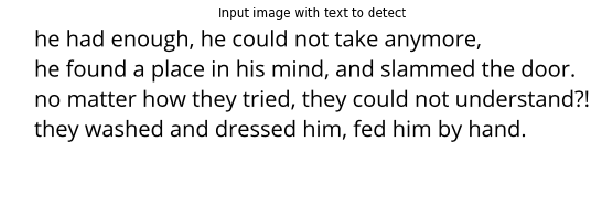

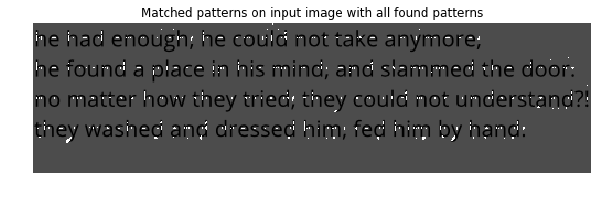

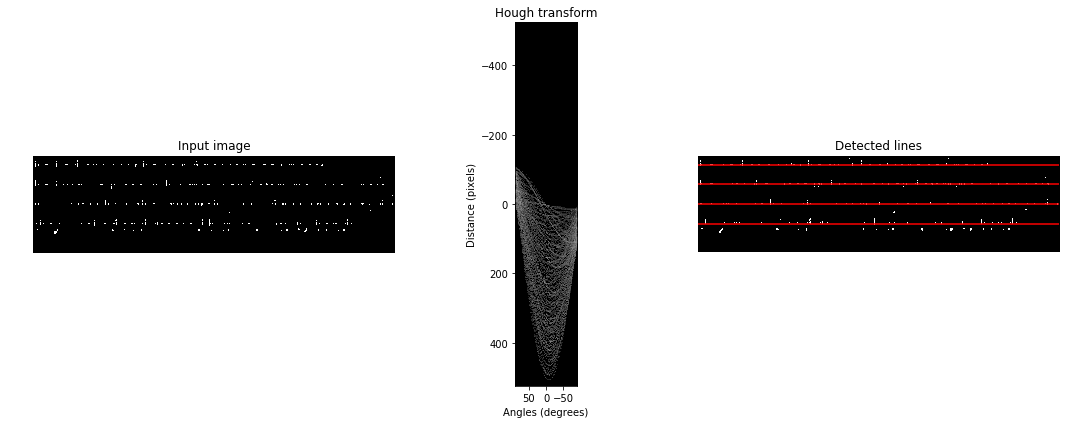

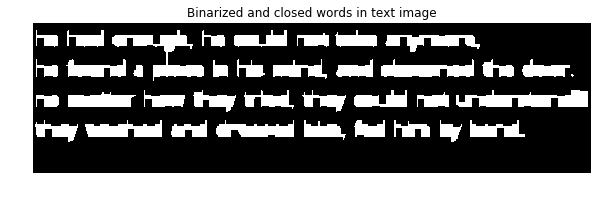

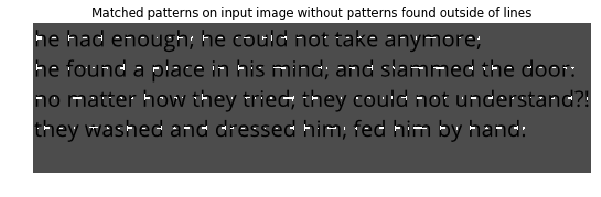

Original:

he had enough, he could not take anymore,
he found a place in his mind, and slammed the door.
no matter how they tried, they could not understand?!
they washed and dressed him, fed him by hand.

OCR result:

he had enough, he could not take anymore,
he foxund a place in his mind , and s!ammed tme door.
no mattzr howv thzy ur led they cou!d not undzrstand
they washed and dressed him, fed h lmby hand.


Original signs dictionary:

OrderedDict([('\n', 3), (' ', 33), ('!', 1), (',', 5), ('.', 2), ('?', 1), ('a', 12), ('b', 1), ('c', 3), ('d', 17), ('e', 19), ('f', 2), ('g', 1), ('h', 15), ('i', 6), ('k', 1), ('l', 4), ('m', 7), ('n', 13), ('o', 11), ('p', 1), ('r', 6), ('s', 6), ('t', 11), ('u', 5), ('w', 2), ('y', 5)])

OCR result signs dictionary:

OrderedDict([('\n', 4), (' ', 35), ('!', 2), (',', 4), ('.', 2), ('a', 12), ('b', 1), ('c', 3), ('d', 17), ('e', 16), ('f', 2), ('g', 1), ('h', 14), ('i', 4), ('k', 1), ('l', 4), ('m', 8), ('n', 13), ('o', 11), ('p', 1), ('r', 6), (

In [24]:
text_image = image_matrix('images/texts/sans_serif/text_1.png')
text_1_sans_serif = ocr_recognize_text(text_image, my_signs, font_type='sans_serif')
measure_ocr_accuracy(text_1, text_1_sans_serif)

## Tekst nr 1 - wersja z czionką szeryfową

In [ ]:
text_image = image_matrix('images/texts/serif/text_1.png')
text_1_serif = ocr_recognize_text(text_image, my_signs, font_type='serif', square_size=3)

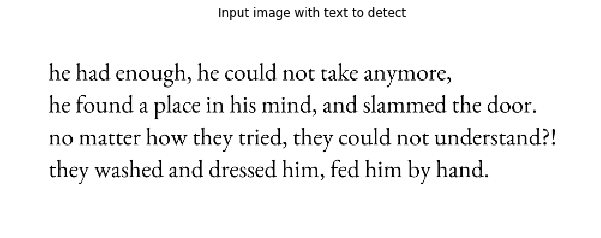

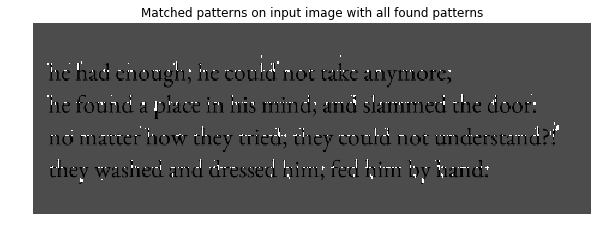

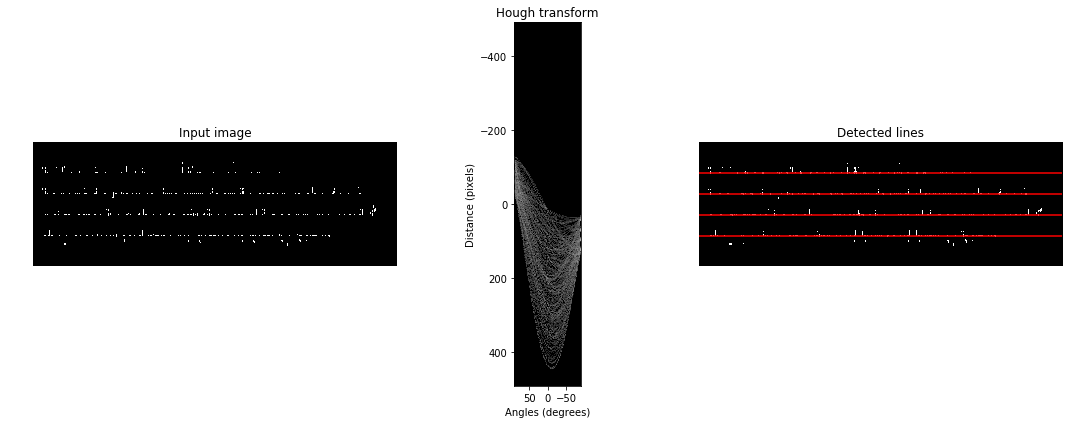

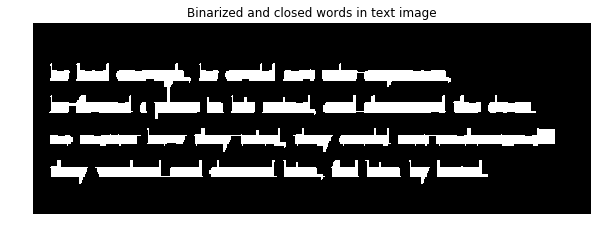

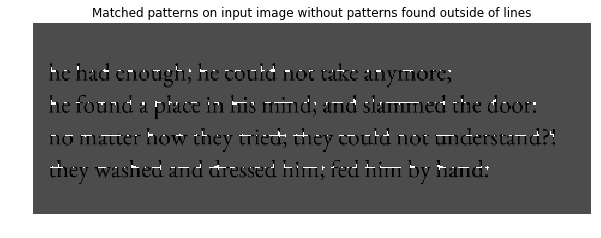

Original:

he had enough, he could not take anymore,
he found a place in his mind, and slammed the door.
no matter how they tried, they could not understand?!
they washed and dressed him, fed him by hand.

OCR result:

h ea ? en ough , h e couk ? n q? ta?e amm o rc,
he fomm d a pkace im ms mmd, aud samexd tb e q or.
n o m uer how theyqied hey cqukd notm derstam ??
dey washeq amd dessexd him, fexd bm by hamd .


Original signs dictionary:

OrderedDict([('\n', 3), (' ', 33), ('!', 1), (',', 5), ('.', 2), ('?', 1), ('a', 12), ('b', 1), ('c', 3), ('d', 17), ('e', 19), ('f', 2), ('g', 1), ('h', 15), ('i', 6), ('k', 1), ('l', 4), ('m', 7), ('n', 13), ('o', 11), ('p', 1), ('r', 6), ('s', 6), ('t', 11), ('u', 5), ('w', 2), ('y', 5)])

OCR result signs dictionary:

OrderedDict([('\n', 4), (' ', 47), (',', 4), ('.', 2), ('?', 6), ('a', 11), ('b', 3), ('c', 4), ('d', 13), ('e', 18), ('f', 2), ('g', 1), ('h', 10), ('i', 3), ('k', 3), ('m', 16), ('n', 4), ('o', 8), ('p', 1), ('q', 5), ('r', 4), ('s

In [25]:
measure_ocr_accuracy(text_1, text_1_serif)

## Tekst nr 1 - wersja z czionką bezszeryfową, z szumem

In [ ]:
text_image = image_matrix('images/texts/sans_serif/text_1_with_noise.png')
text_1_with_noise = ocr_recognize_text(text_image, my_signs, font_type='sans_serif', remove_noise=True)

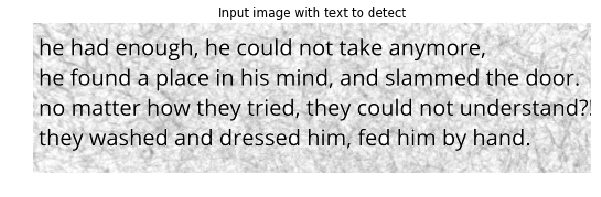

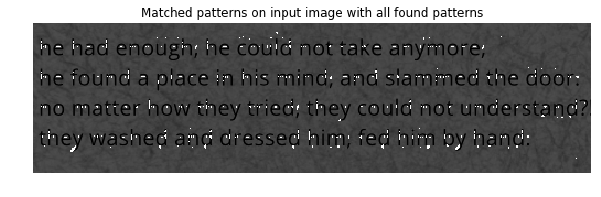

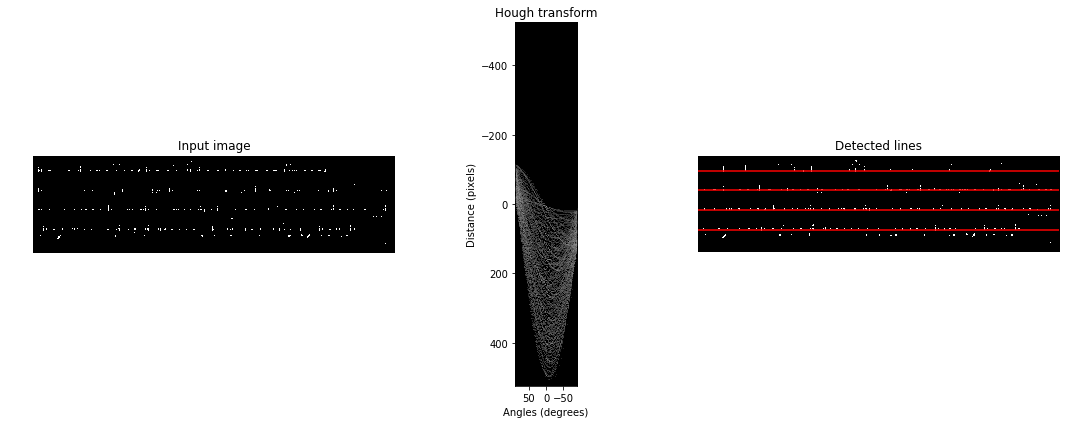

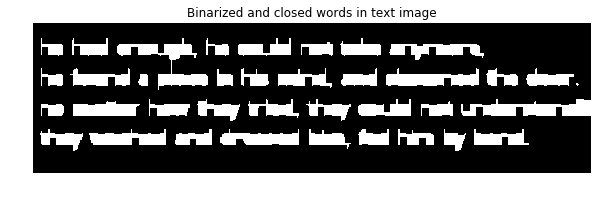

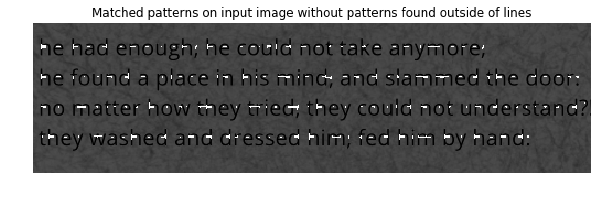

Original:

he had enough, he could not take anymore,
he found a place in his mind, and slammed the door.
no matter how they tried, they could not understand?!
they washed and dressed him, fed him by hand.

OCR result:

he had enough, he cox uld not take anymore,
he found a place in his mind and s!ammed tme door.
no mattzr howv hzy u ied zhey cou!d not undzrstand
they washed and dressed hm, fed h im by hand.


Original signs dictionary:

OrderedDict([('\n', 3), (' ', 33), ('!', 1), (',', 5), ('.', 2), ('?', 1), ('a', 12), ('b', 1), ('c', 3), ('d', 17), ('e', 19), ('f', 2), ('g', 1), ('h', 15), ('i', 6), ('k', 1), ('l', 4), ('m', 7), ('n', 13), ('o', 11), ('p', 1), ('r', 6), ('s', 6), ('t', 11), ('u', 5), ('w', 2), ('y', 5)])

OCR result signs dictionary:

OrderedDict([('\n', 4), (' ', 36), ('!', 2), (',', 3), ('.', 2), ('a', 12), ('b', 1), ('c', 3), ('d', 17), ('e', 16), ('f', 2), ('g', 1), ('h', 14), ('i', 5), ('k', 1), ('l', 2), ('m', 8), ('n', 13), ('o', 11), ('p', 1), ('r', 5), ('s'

In [26]:
measure_ocr_accuracy(text_1, text_1_with_noise)

## Tekst nr 2 - wersja z czionką bezszeryfową

In [ ]:
text_image = image_matrix('images/texts/sans_serif/text_2.png')
text_2_sans_serif = ocr_recognize_text(text_image, my_signs, font_type='sans_serif', correlation_treshold=0.81)

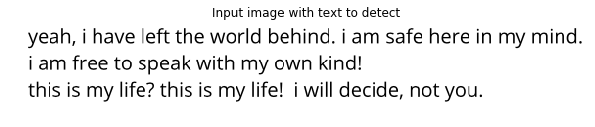

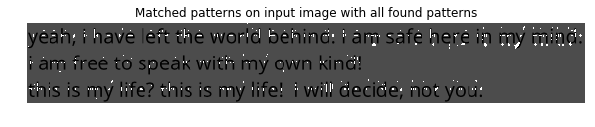

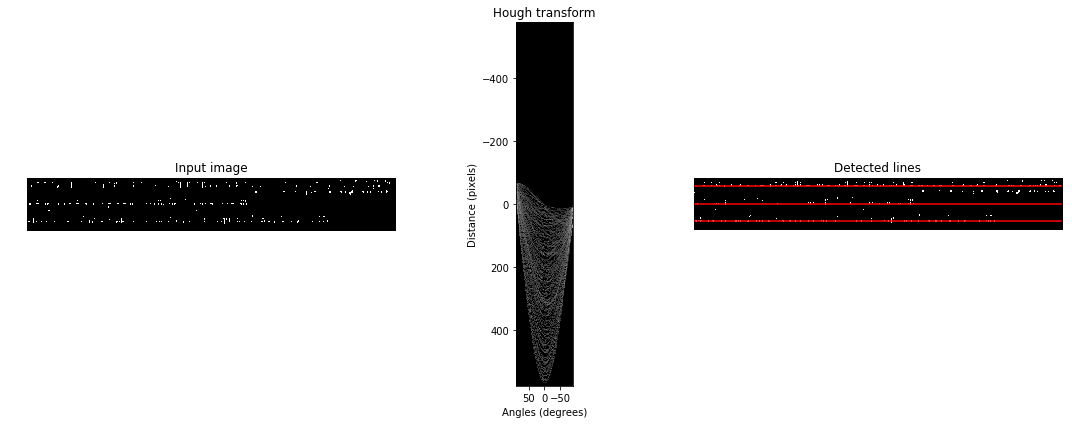

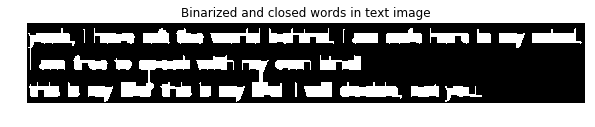

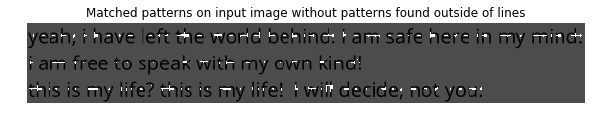

Original:

yeah, i have left the world behind. i am safe here in my mind.
i am free to speak with my own kind!
this is my life? this is my life! i will decide, not you.

OCR result:

yeah, r have left me wpnd beh ind r am safe here in my mind
r am free to speak witm my own kind!
his ls my llfe mls ls my !ifel j wlg decde, not you .


Original signs dictionary:

OrderedDict([('\n', 2), (' ', 33), ('!', 2), (',', 2), ('.', 3), ('?', 1), ('a', 6), ('b', 1), ('c', 1), ('d', 6), ('e', 15), ('f', 5), ('h', 8), ('i', 17), ('k', 2), ('l', 6), ('m', 7), ('n', 6), ('o', 5), ('p', 1), ('r', 3), ('s', 6), ('t', 7), ('u', 1), ('v', 1), ('w', 4), ('y', 6)])

OCR result signs dictionary:

OrderedDict([('\n', 3), (' ', 35), ('!', 2), (',', 2), ('.', 1), ('a', 6), ('b', 1), ('c', 1), ('d', 6), ('e', 15), ('f', 5), ('g', 1), ('h', 5), ('i', 7), ('j', 1), ('k', 2), ('l', 8), ('m', 10), ('n', 7), ('o', 4), ('p', 2), ('r', 5), ('s', 6), ('t', 4), ('u', 1), ('v', 1), ('w', 4), ('y', 6)])


In [27]:
measure_ocr_accuracy(text_2, text_2_sans_serif)

## Tekst nr 2 - wersja z czionką szeryfową

In [ ]:
text_image = image_matrix('images/texts/serif/text_2.png')
text_2_serif = ocr_recognize_text(text_image, my_signs, font_type='serif', correlation_treshold=0.81, square_size=2)

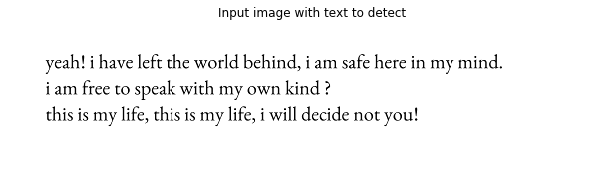

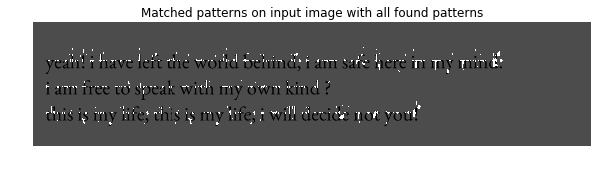

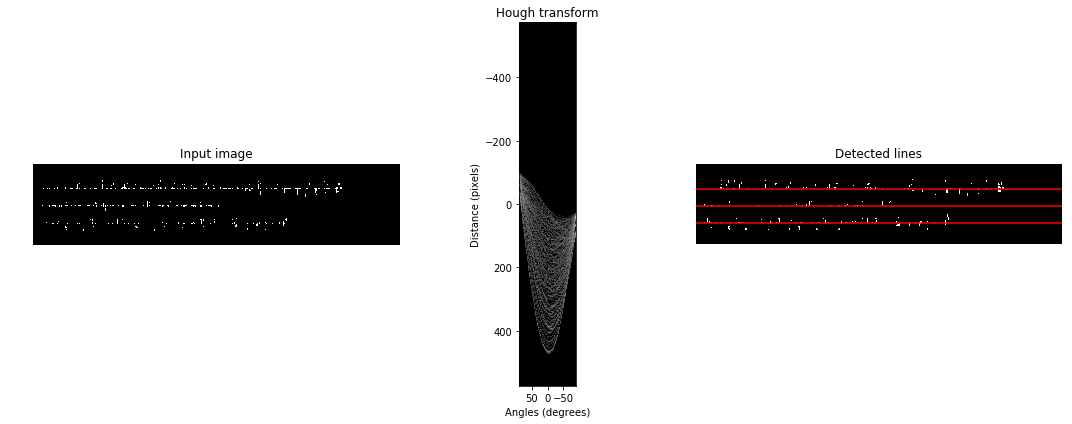

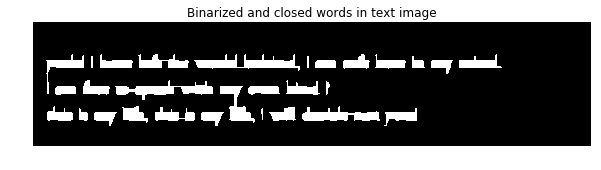

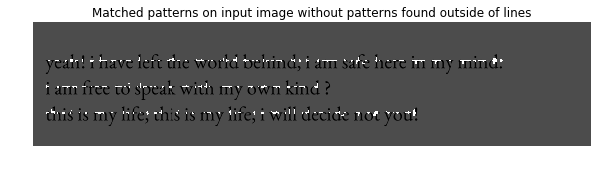

Original:

yeah, i have left the world behind. i am safe here in my mind.
i am free to speak with my own kind!
this is my life? this is my life! i will decide, not you.

OCR result:

yeamh! f h ave eft?h e wxor?k? bxelmmm ? , f am sa?e fhere ? my mum? .
f amn free unx sqpxeakwiudh my owwn kqm d
fqhus js my lhie , fdis is nmylif, f xwi!l x deci?e ? o? x?xou?


Original signs dictionary:

OrderedDict([('\n', 2), (' ', 33), ('!', 2), (',', 2), ('.', 3), ('?', 1), ('a', 6), ('b', 1), ('c', 1), ('d', 6), ('e', 15), ('f', 5), ('h', 8), ('i', 17), ('k', 2), ('l', 6), ('m', 7), ('n', 6), ('o', 5), ('p', 1), ('r', 3), ('s', 6), ('t', 7), ('u', 1), ('v', 1), ('w', 4), ('y', 6)])

OCR result signs dictionary:

OrderedDict([('\n', 3), (' ', 39), ('!', 2), (',', 3), ('.', 1), ('?', 12), ('a', 6), ('b', 1), ('c', 1), ('d', 4), ('e', 14), ('f', 10), ('h', 7), ('i', 7), ('j', 1), ('k', 3), ('l', 4), ('m', 13), ('n', 4), ('o', 4), ('p', 1), ('q', 3), ('r', 3), ('s', 6), ('t', 1), ('u', 5), ('v', 1), ('

In [28]:
measure_ocr_accuracy(text_2, text_2_serif)

## Tekst nr 3 - wersja z czionką bezszeryfową

In [ ]:
text_image = image_matrix('images/texts/sans_serif/text_3.png')
text_3_sans_serif = ocr_recognize_text(text_image, my_signs, font_type='sans_serif', correlation_treshold=0.81)

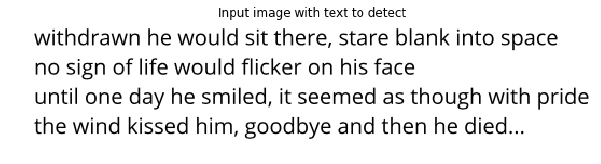

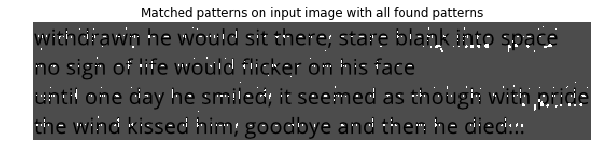

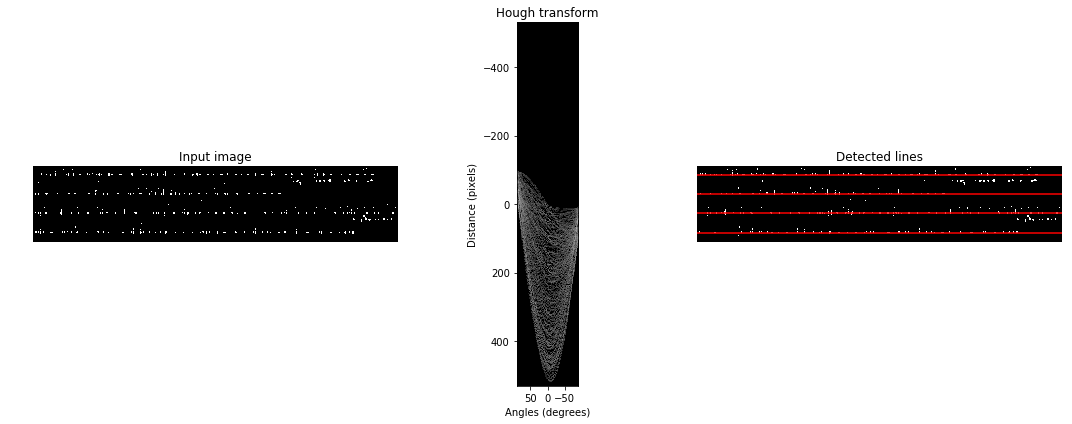

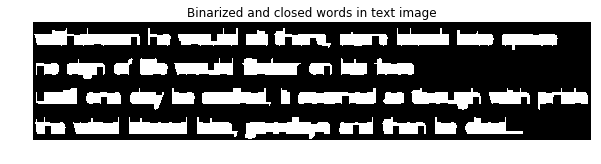

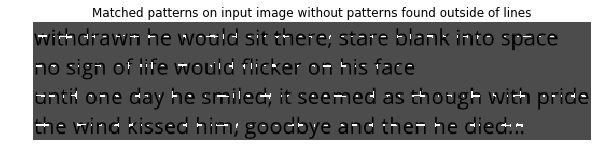

Original:

withdrawn he would sit there, stare blank into space
no sign of life would flicker on his face
until one day he smiled, it seemed as though with pride
the wind kissed him, goodbye and then he died...

OCR result:

wimdrawvn he would sit tmere, star e blamk into space
no sign of life wpuld flicker on his face
untl one day he smlled lt seemed as mough wlh pr lde
he wlnd kissed hlm, gopdbye and tmen he died .


Original signs dictionary:

OrderedDict([('\n', 3), (' ', 34), (',', 3), ('.', 3), ('a', 8), ('b', 2), ('c', 3), ('d', 13), ('e', 21), ('f', 4), ('g', 3), ('h', 12), ('i', 16), ('k', 3), ('l', 7), ('m', 3), ('n', 11), ('o', 10), ('p', 2), ('r', 5), ('s', 10), ('t', 11), ('u', 4), ('w', 6), ('y', 2)])

OCR result signs dictionary:

OrderedDict([('\n', 4), (' ', 37), (',', 2), ('.', 1), ('a', 8), ('b', 2), ('c', 3), ('d', 13), ('e', 21), ('f', 4), ('g', 3), ('h', 8), ('i', 9), ('k', 3), ('l', 13), ('m', 8), ('n', 10), ('o', 8), ('p', 4), ('r', 5), ('s', 10), ('t', 7), ('u'

In [29]:
measure_ocr_accuracy(text_3, text_3_sans_serif)

## Tekst nr 3 - wersja z czionką szeryfową

In [ ]:
text_image = image_matrix('images/texts/serif/text_3.png')
text_3_serif = ocr_recognize_text(text_image, my_signs, font_type='serif', correlation_treshold=0.80, square_size=2)

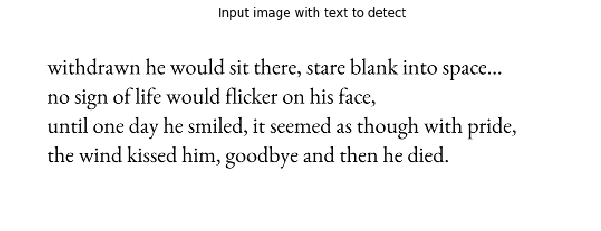

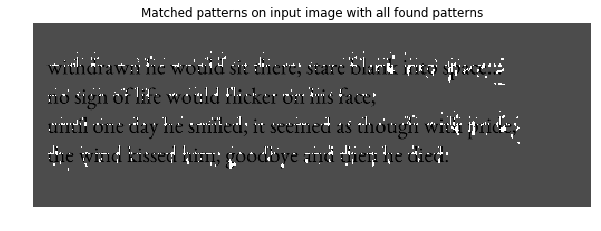

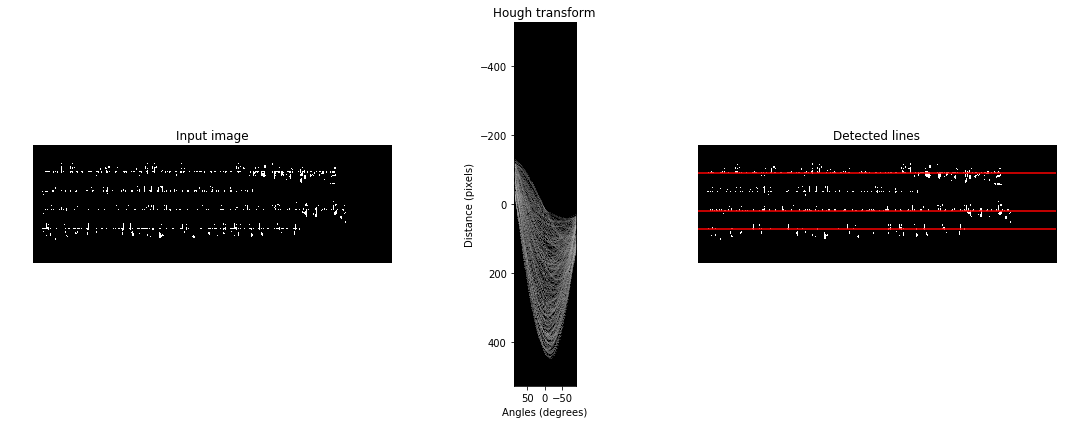

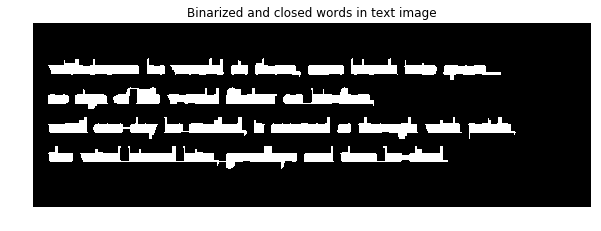

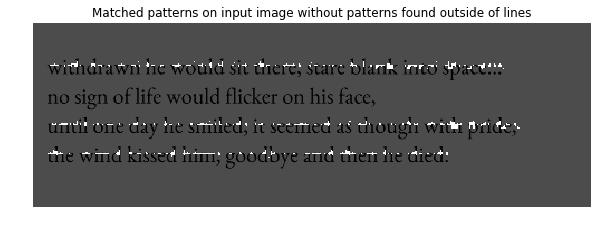

Original:

withdrawn he would sit there, stare blank into space
no sign of life would flicker on his face
until one day he smiled, it seemed as though with pride
the wind kissed him, goodbye and then he died...

OCR result:

wj?h ?hawmr fh ? ?quil? sju f?h e?, staure blam? im??x ?x a c? . . .
mmumil x uxne xday fhe smiexd, iu scemexd as dhuuigh wu? ?x?i??,
me wmd kqssexd mm, goodbye amx? mem fhie xdhex? .


Original signs dictionary:

OrderedDict([('\n', 3), (' ', 34), (',', 3), ('.', 3), ('a', 8), ('b', 2), ('c', 3), ('d', 13), ('e', 21), ('f', 4), ('g', 3), ('h', 12), ('i', 16), ('k', 3), ('l', 7), ('m', 3), ('n', 11), ('o', 10), ('p', 2), ('r', 5), ('s', 10), ('t', 11), ('u', 4), ('w', 6), ('y', 2)])

OCR result signs dictionary:

OrderedDict([('\n', 3), (' ', 36), (',', 4), ('.', 4), ('?', 19), ('a', 7), ('b', 2), ('c', 2), ('d', 8), ('e', 13), ('f', 4), ('g', 2), ('h', 9), ('i', 8), ('j', 2), ('k', 1), ('l', 3), ('m', 15), ('n', 1), ('o', 2), ('q', 2), ('r', 2), ('s', 7), ('t', 1)

In [30]:
measure_ocr_accuracy(text_3, text_3_serif)

## Tekst nr 4 - wersja z czionką bezszeryfową

In [ ]:
text_image = image_matrix('images/texts/sans_serif/text_4.png')
text_4_sans_serif = ocr_recognize_text(text_image, my_signs_with_numbers, font_type='sans_serif', square_size=3)

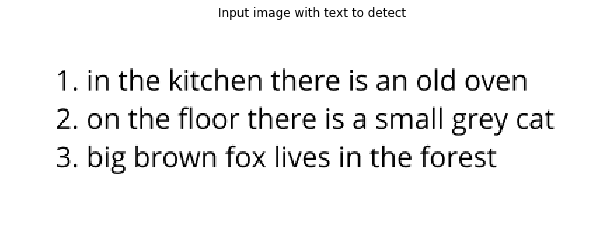

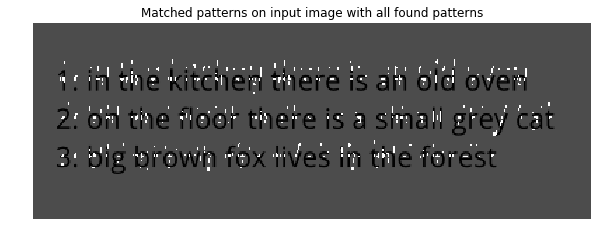

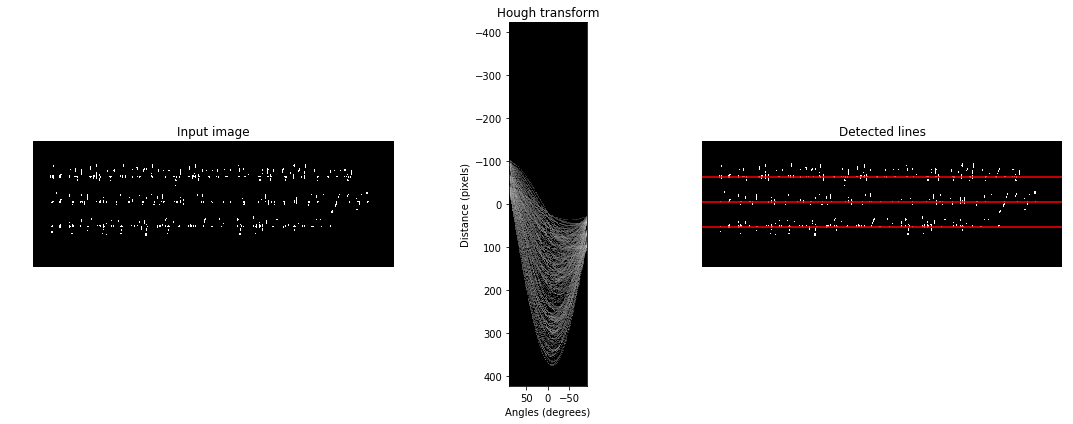

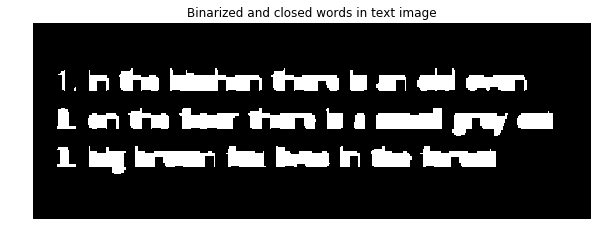

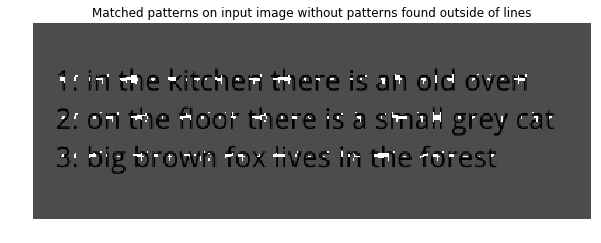

Original:

1. in the kitchen there is an old oven
2. on the floor there is a small grey cat
3. big brown fox lives in the forest

OCR result:

1 . im me kiuchen mere is am old pven
2. om mhe 0oor mhere6 ls a sma4 gry cat
3. big browv4n fmx 4ves i n me fmrest


Original signs dictionary:

OrderedDict([('\n', 2), (' ', 24), ('.', 3), ('1', 1), ('2', 1), ('3', 1), ('a', 4), ('b', 2), ('c', 2), ('d', 1), ('e', 12), ('f', 3), ('g', 2), ('h', 6), ('i', 7), ('k', 1), ('l', 5), ('m', 1), ('n', 7), ('o', 8), ('r', 6), ('s', 5), ('t', 8), ('v', 2), ('w', 1), ('x', 1), ('y', 1)])

OCR result signs dictionary:

OrderedDict([('\n', 3), (' ', 26), ('.', 3), ('0', 1), ('1', 1), ('2', 1), ('3', 1), ('4', 3), ('6', 1), ('a', 4), ('b', 2), ('c', 2), ('d', 1), ('e', 11), ('f', 2), ('g', 2), ('h', 3), ('i', 5), ('k', 1), ('l', 2), ('m', 11), ('n', 4), ('o', 5), ('p', 1), ('r', 6), ('s', 5), ('t', 2), ('u', 1), ('v', 3), ('w', 1), ('x', 1), ('y', 1)])


In [31]:
measure_ocr_accuracy(text_4, text_4_sans_serif)

## Tekst nr 4 - wersja z czionką szeryfową

In [ ]:
text_image = image_matrix('images/texts/serif/text_4.png')
text_4_serif = ocr_recognize_text(text_image, my_signs_with_numbers, font_type='serif', square_size=3)

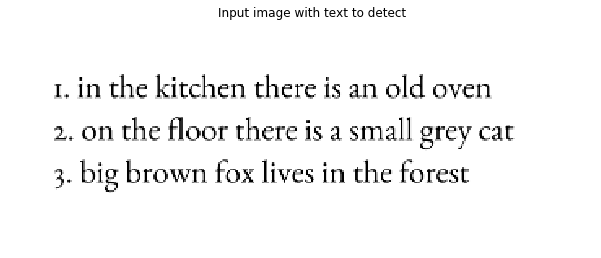

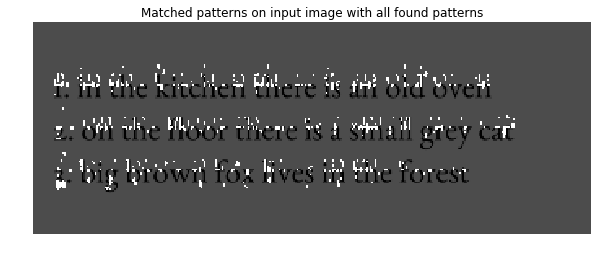

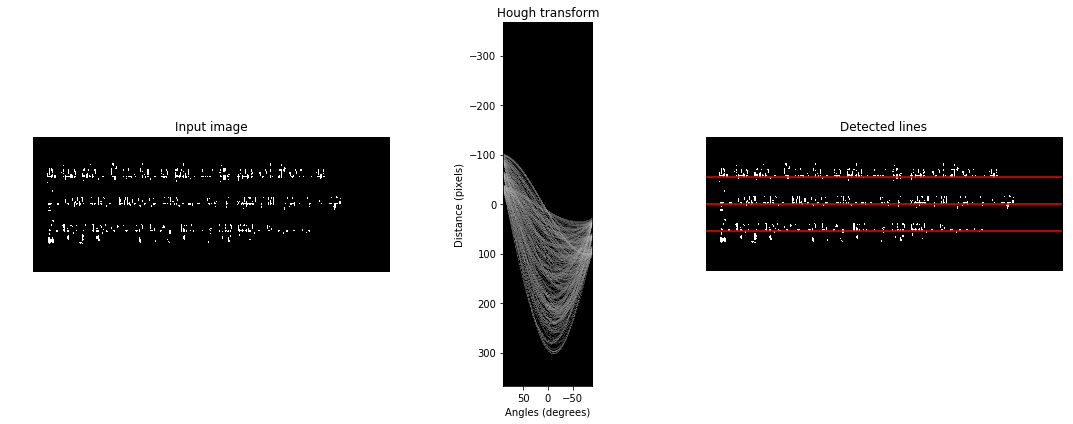

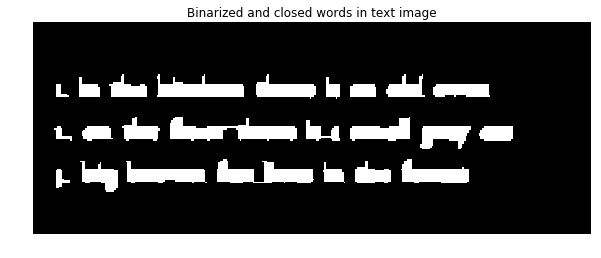

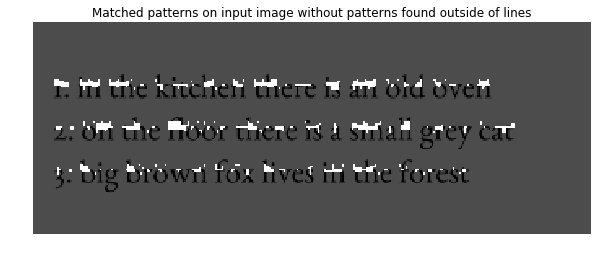

Original:

1. in the kitchen there is an old oven
2. on the floor there is a small grey cat
3. big brown fox lives in the forest

OCR result:

? m ?e kmchem ?em ? m 0k? ?we?
2 . bm de f0 0rhe6e s a mah g6ey c?
3 . big b4r0wn fox hwes m he f0rest


Original signs dictionary:

OrderedDict([('\n', 2), (' ', 24), ('.', 3), ('1', 1), ('2', 1), ('3', 1), ('a', 4), ('b', 2), ('c', 2), ('d', 1), ('e', 12), ('f', 3), ('g', 2), ('h', 6), ('i', 7), ('k', 1), ('l', 5), ('m', 1), ('n', 7), ('o', 8), ('r', 6), ('s', 5), ('t', 8), ('v', 2), ('w', 1), ('x', 1), ('y', 1)])

OCR result signs dictionary:

OrderedDict([('\n', 3), (' ', 26), ('.', 2), ('0', 5), ('2', 1), ('3', 1), ('4', 1), ('6', 2), ('?', 8), ('a', 2), ('b', 3), ('c', 2), ('d', 1), ('e', 11), ('f', 3), ('g', 2), ('h', 5), ('i', 1), ('k', 2), ('m', 8), ('n', 1), ('o', 1), ('r', 3), ('s', 3), ('t', 1), ('w', 3), ('x', 1), ('y', 1)])


In [32]:
measure_ocr_accuracy(text_4, text_4_serif)

# Wnioski i spotrzeżenia

- dla czcionki bezszeryfowej wyniki działania algorytmu są znacznie lepsze niż dla szeryfowej,
- dla zbioru znaków bez cyfr również uzyskiwane są lepsze wyniki działania,
- sposób działania algorytmu opiera się na analizie dopasowych wzorców na całym obrazie, a nie na wyizolowaniu znaków i dopasowaniu ich do znaków wzorcoych, stąd jego działanie nie wykrywa tej samej ilości znaków, zdarza się, że dwa znaki obok siebie są rozpoznane jako jeden, lub że pomiędzy dwoma znakami został rozpoznany jakiś inny przypadkowy znak,
- takie podejście dla czcionek bezszeryfowych daje zaskakująco dobre rezultaty, co pokazuje obraz Tekst 1,
- niestety pomimo prób wykorzystania transformacji Hougha do znalezienia kątu obrotu dla tekstów obróconych nie udało mi się zrealizować tej funckjonalności.